

---


# Class incremental learning on the GTSRB dataset



---


This notebook contains several code snippets to help for your project:

- data loaders
- A baseline for incremental learning using fine-tuning
- Examples of how to use Weight & Biases for logging your results.



In [54]:
####################################
### Useful imports
############################

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.transforms import v2
import copy

import numpy as np
import random
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [55]:
# # Useful if you want to store intermediate results on your drive
# from google.colab import drive

# # Useful if you want to store intermediate results on your drive from google.colab import drive

# drive.mount('/content/gdrive/')
# DATA_DIR =  '/content/gdrive/MyDrive/teaching/ENSTA/2024'


In [56]:
# Check if GPU is available
if torch.cuda.is_available():
  !nvidia-smi

## Data loaders

In [57]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
])

transform_train = v2.Compose([
    #v2.Grayscale(),
    #v2.RandomResizedCrop(32),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

# Define dataset and dataloader
def get_dataset(root_dir, transform, train=True):
    dataset = datasets.GTSRB(root=root_dir, split='train' if train else 'test', download=True, transform=transform)
    target = [data[1] for data in dataset]
    return dataset, target

def create_dataloader(dataset, targets, current_classes, batch_size, shuffle):
    indices = [i for i, label in enumerate(targets) if label in current_classes]
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [58]:
# Loads datasets (on your local computer)
root_dir = '/home/stephane/Documents/Onera/Cours/ENSTA/2025/data'

# Loads datasets (on Colab local computer)
root_dir = './data'

train_dataset = datasets.GTSRB(root=root_dir, split='train', download=True, transform=transform_train)
test_dataset = datasets.GTSRB(root=root_dir, split='test', download=True, transform=transform_test)

print(f"Train dataset contains {len(train_dataset)} images")
print(f"Test dataset contains {len(test_dataset)} images")

# Loads target id lists and class names (not in torchvision dataset)
import csv
data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/test_target.csv', delimiter=',', header=None)
test_target = data.to_numpy().squeeze().tolist()

data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/train_target.csv', delimiter=',', header=None)
train_target = data.to_numpy().squeeze().tolist()

data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/signnames.csv')
class_names = data['SignName'].tolist()

Train dataset contains 26640 images
Test dataset contains 12630 images


## Display of images

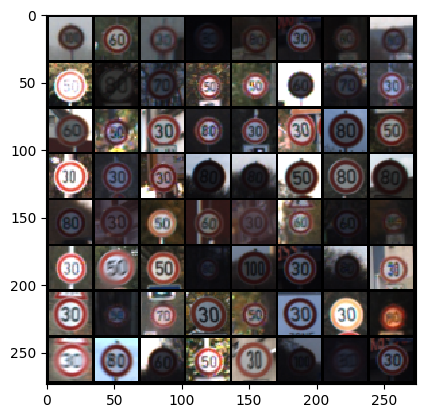

torch.Size([64, 3, 32, 32])


In [59]:
nclasses = len(np.unique(train_target))
all_classes = list(range(nclasses))
#random.shuffle(all_classes)
classes_per_task = 8
current_classes = []

task = 0
task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
current_classes.extend(task_classes)
batch_size = 64

# Create data for first task
train_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)
test_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)

# Displays a few examples
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(train_loader))
show(make_grid(sample))
plt.show()

print(sample.shape)     ## 64 is the batch
                        ## 1 for grey values --  3 for RGB
                        ## 32x32 for mage size (small here)


In [60]:
test_loader = create_dataloader(train_dataset, train_target, all_classes, batch_size, shuffle = True)

# Get the data from the test set and computes statistics
# gtsrbtest_gt = []
# for _, targets in test_loader:
#   gtsrbtest_gt += targets.numpy().tolist()
# print(len(gtsrbtest_gt))

from collections import Counter

label_counts = Counter(test_target).most_common()
for l, c in label_counts:
    print(c, '\t', l, '\t', class_names[l])

750 	 2 	 Speed limit (50km/h)
720 	 1 	 Speed limit (30km/h)
720 	 13 	 Yield
690 	 38 	 Keep right
690 	 12 	 Priority road
660 	 4 	 Speed limit (70km/h)
660 	 10 	 No passing for vechiles over 3.5 metric tons
630 	 5 	 Speed limit (80km/h)
480 	 25 	 Road work
480 	 9 	 No passing
450 	 7 	 Speed limit (100km/h)
450 	 3 	 Speed limit (60km/h)
450 	 8 	 Speed limit (120km/h)
420 	 11 	 Right-of-way at the next intersection
390 	 18 	 General caution
390 	 35 	 Ahead only
360 	 17 	 No entry
270 	 14 	 Stop
270 	 31 	 Wild animals crossing
210 	 33 	 Turn right ahead
210 	 15 	 No vechiles
180 	 26 	 Traffic signals
150 	 16 	 Vechiles over 3.5 metric tons prohibited
150 	 23 	 Slippery road
150 	 30 	 Beware of ice/snow
150 	 28 	 Children crossing
150 	 6 	 End of speed limit (80km/h)
120 	 34 	 Turn left ahead
120 	 22 	 Bumpy road
120 	 36 	 Go straight or right
90 	 21 	 Double curve
90 	 20 	 Dangerous curve to the right
90 	 24 	 Road narrows on the right
90 	 29 	 Bicycles cr

## Simple networks

In [61]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self,n_out=10, n_in=1):
        super().__init__()

        # Put the layers here
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.fc = nn.Linear(4096, n_out)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x)) ## l'image 1x32x32 devient 32x32x32
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis 32x16x16
        x = F.leaky_relu(self.conv2(x)) ## puis devient 64x16x16
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis devient 64x8x8
        x = F.leaky_relu(self.conv3(x)) ## pas de changement

        x = x.view(-1,4096) ## 64x8x8 devient 4096

        x = self.fc(x) ## on finit exactement de la même façon

        return x

# Another simple model (compare them using torchinfo below)
class SimpleCNN2(nn.Module):
    def __init__(self, n_out=10, n_in=1):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc = nn.Linear(128, n_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc(x)
        return x

In [62]:
!pip install torchinfo
from torchinfo import summary

model = SimpleCNN2(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

model = SimpleCNN(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

#print(model)

1832149.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN2                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─ReLU: 1-2                              [64, 32, 32, 32]          --
├─MaxPool2d: 1-3                         [64, 32, 16, 16]          --
├─Conv2d: 1-4                            [64, 64, 16, 16]          18,496
├─ReLU: 1-5                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-6                         [64, 64, 8, 8]            --
├─Linear: 1-7                            [64, 128]                 524,416
├─ReLU: 1-8                              [64, 128]                 --
├─Linear: 1-9                            [64, 10]                  1,290
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
Total mult-adds (M): 395.40
Input size (MB): 0.79
Forward/backward pass size (MB): 25.24
Params size (MB): 2.18
Estimated Total Size (MB): 2

## Baseline for incremental learning

In [63]:
from torch.optim import lr_scheduler
import torch.nn.init as init

# Evaluation
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, ncols=80):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Simple Training loop
def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()

    for images, labels in tqdm(train_loader, ncols=80,  desc="Epoch {}".format(epoch)):   #ajouter d'autres données, techniques memory buffer,
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def initialize_weights(module):
    """Initializes the weights of a PyTorch module using Xavier/Glorot initialization."""
    if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):  # Check for relevant layers
        init.xavier_uniform_(module.weight) #Xavier uniform initialization
        if module.bias is not None:
            init.zeros_(module.bias)  # Initialize bias to zero
    elif isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)): #Initialize normalization layers
        if module.weight is not None:
            init.ones_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)


# Main training loop for incremental learning
def incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss() #peut être changé comme critère
    current_classes = []
    accuracies = []

    for task in range(num_tasks):
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs as needed
            train(model, train_loader, optimizer, criterion, device, epoch)
            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")
        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

    return accuracies



## Incremental Learning with Rehearsal and Knowledge Distillation

This section implements an incremental learning strategy that introduces new road sign classes sequentially while minimizing catastrophic forgetting. The approach combines:

1. Rehearsal : A memory buffer stores a subset of previous examples to retain past knowledge.
2. Knowledge Distillation (KD) : The model leverages outputs from an earlier version to maintain performance on previously learned classes.

The method is tested with and without Weights & Biases (WandB) logging to track performance across tasks. The evaluation metric is incremental accuracy, measuring the model's ability to recognize all previously seen classes as new ones are added.

In [72]:
#Memory Buffer Class
class MemoryBuffer:
    """
    A memory buffer to store previous examples for rehearsal.
    """
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.images = []
        self.labels = []
        self.class_indices = {}  # To keep track of examples per class
        
    def update(self, images, labels, new_classes):
        """Update buffer with new examples, maintaining balanced classes."""
        # Convert tensors to numpy for storage if needed
        if isinstance(images, torch.Tensor):
            images_np = images.cpu().numpy()
        else:
            images_np = images
            
        if isinstance(labels, torch.Tensor):
            labels_np = labels.cpu().numpy()
        else:
            labels_np = labels
        
        # Initialize class indices for new classes
        for cls in new_classes:
            if cls not in self.class_indices:
                self.class_indices[cls] = []
        
        # Add new examples to buffer
        for i, (image, label) in enumerate(zip(images_np, labels_np)):
            if label in new_classes:
                self.images.append(image)
                self.labels.append(label)
                self.class_indices[label].append(len(self.images) - 1)
        
        # Ensure buffer doesn't exceed size limit by randomly removing samples
        self._balance_buffer()
    
    def _balance_buffer(self):
        """Balance the buffer to ensure equal representation of classes."""
        if len(self.images) <= self.buffer_size:
            return
        
        # Calculate how many samples per class we should keep
        num_classes = len(self.class_indices)
        samples_per_class = self.buffer_size // num_classes
        
        # Select indices to keep
        indices_to_keep = []
        for cls, idx_list in self.class_indices.items():
            if len(idx_list) > samples_per_class:
                # Randomly select samples for this class
                selected = random.sample(idx_list, samples_per_class)
                indices_to_keep.extend(selected)
            else:
                # Keep all samples for this class
                indices_to_keep.extend(idx_list)
        
        # If we still haven't filled the buffer, add more samples randomly
        remaining_slots = self.buffer_size - len(indices_to_keep)
        if remaining_slots > 0:
            remaining_indices = [i for i in range(len(self.images)) if i not in indices_to_keep]
            if remaining_indices:
                additional_indices = random.sample(remaining_indices, min(remaining_slots, len(remaining_indices)))
                indices_to_keep.extend(additional_indices)
        
        # Keep only the selected indices
        new_images = [self.images[i] for i in indices_to_keep]
        new_labels = [self.labels[i] for i in indices_to_keep]
        
        # Update the buffer
        self.images = new_images
        self.labels = new_labels
        
        # Update class indices
        self.class_indices = {}
        for i, label in enumerate(self.labels):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(i)
    
    def get_batch(self, batch_size):
        """Get a random batch from the buffer."""
        if len(self.images) == 0:
            return None, None
        
        indices = random.sample(range(len(self.images)), min(batch_size, len(self.images)))
        batch_images = [self.images[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]
        
        return torch.tensor(batch_images), torch.tensor(batch_labels)
    
    def __len__(self):
        return len(self.images)


#Knowledge Distillation Loss
def distillation_loss(outputs, targets, old_outputs, T=2.0, alpha=0.5):
    """
    Compute the knowledge distillation loss.
    
    Args:
        outputs: Current model outputs
        targets: Ground truth labels
        old_outputs: Outputs from the old model (before learning new classes)
        T: Temperature for softening the distributions
        alpha: Weight for balancing classification loss and distillation loss
    
    Returns:
        Combined loss: classification loss + distillation loss
    """
    # Standard cross entropy loss
    ce_loss = F.cross_entropy(outputs, targets)
    
    # Knowledge distillation loss
    if old_outputs is not None:
        # Apply temperature scaling
        scaled_outputs = outputs[:, :old_outputs.size(1)] / T
        scaled_old_outputs = old_outputs / T
        
        # Compute KL divergence loss
        kd_loss = F.kl_div(
            F.log_softmax(scaled_outputs, dim=1),
            F.softmax(scaled_old_outputs, dim=1),
            reduction='batchmean'
        ) * (T * T)
        
        # Combine losses
        return alpha * ce_loss + (1 - alpha) * kd_loss
    else:
        return ce_loss


#Training with Rehearsal and Knowledge Distillation
def train_rehearsal_kd(model, old_model, train_loader, memory_buffer, optimizer, device, epoch, 
                       alpha=0.5, T=2.0, rehearsal_ratio=0.3):
    """
    Training loop with rehearsal and knowledge distillation.
    
    Args:
        model: Current model being trained
        old_model: Model from previous task (for knowledge distillation)
        train_loader: DataLoader for current task data
        memory_buffer: Memory buffer containing examples from previous tasks
        optimizer: Optimizer for model parameters
        device: Device to run computation on
        epoch: Current epoch number
        alpha: Weight for balancing classification and distillation loss
        T: Temperature for knowledge distillation
        rehearsal_ratio: Ratio of rehearsal batch size to current batch size
    """
    model.train()
    if old_model is not None:
        old_model.eval()
    
    for images, labels in tqdm(train_loader, ncols=80, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        
        # Add rehearsal data if available
        if memory_buffer is not None and len(memory_buffer) > 0:
            rehearsal_batch_size = max(1, int(images.size(0) * rehearsal_ratio))
            mem_images, mem_labels = memory_buffer.get_batch(rehearsal_batch_size)
            
            if mem_images is not None and mem_images.size(0) > 0:
                mem_images, mem_labels = mem_images.to(device), mem_labels.to(device)
                combined_images = torch.cat([images, mem_images], dim=0)
                combined_labels = torch.cat([labels, mem_labels], dim=0)
            else:
                combined_images, combined_labels = images, labels
        else:
            combined_images, combined_labels = images, labels
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(combined_images)
        
        # Compute knowledge distillation loss if old model exists
        if old_model is not None:
            with torch.no_grad():
                old_outputs = old_model(combined_images)
            loss = distillation_loss(outputs, combined_labels, old_outputs, T=T, alpha=alpha)
        else:
            loss = F.cross_entropy(outputs, combined_labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()


#Incremental Learning with Rehearsal and KD
def incremental_learning_rehearsal_kd(model, train_dataset, train_target, test_dataset, test_target,
                                     num_tasks, classes_per_task, batch_size, num_epochs, lr, device,
                                     buffer_size=200, alpha=0.5, T=2.0):
    """
    Incremental learning with rehearsal and knowledge distillation.
    
    Args:
        model: Model to be trained
        train_dataset, train_target: Training data and targets
        test_dataset, test_target: Test data and targets
        num_tasks: Number of tasks to learn sequentially
        classes_per_task: Number of classes in each task
        batch_size: Batch size for training
        num_epochs: Number of epochs per task
        lr: Learning rate
        device: Device to run computation on
        buffer_size: Size of memory buffer for rehearsal
        alpha: Weight for balancing classification and distillation loss
        T: Temperature for knowledge distillation
    """
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    current_classes = []
    accuracies = []
    
    # Initialize memory buffer
    memory_buffer = MemoryBuffer(buffer_size)
    
    for task in range(num_tasks):
        # Define classes for the current task
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)
        
        # Create data loaders
        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)
        
        # Create a copy of the current model before task learning (for knowledge distillation)
        old_model = copy.deepcopy(model) if task > 0 else None
        if old_model is not None:
            old_model.eval()  # Set to evaluation mode
        
        # Modify the model's output layer for new classes
        if task == 0:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias
        
        # Set up optimizer and scheduler
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        
        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        
        # Training loop for current task
        for epoch in range(num_epochs):
            # Train with rehearsal and knowledge distillation
            train_rehearsal_kd(model, old_model, train_loader, memory_buffer, optimizer, device, epoch, alpha=alpha, T=T)
            scheduler.step()
            
            # Evaluate on training data
            train_accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {train_accuracy:.2f}%")
        
        # After training, update memory buffer with examples from current task
        for images, labels in train_loader:
            memory_buffer.update(images, labels, task_classes)
            break  # Just use one batch to update memory (for efficiency)
        
        # Evaluate on test data (all classes seen so far)
        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")
    
    return accuracies


#Incremental Learning with Rehearsal and KD for WandB
def incremental_learning_rehearsal_kd_wandb(model, train_dataset, train_target, test_dataset, test_target,
                                           num_tasks, classes_per_task, batch_size, num_epochs, lr, device,
                                           buffer_size=200, alpha=0.5, T=2.0):
    """
    Incremental learning with rehearsal and knowledge distillation for WandB logging.
    """
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    current_classes = []
    accuracies = []
    
    # Initialize memory buffer
    memory_buffer = MemoryBuffer(buffer_size)
    
    # Setup WandB metrics
    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")
    
    for task in range(num_tasks):
        # Define classes for the current task
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)
        
        # Create data loaders
        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)
        
        # Create a copy of the current model before task learning (for knowledge distillation)
        old_model = copy.deepcopy(model) if task > 0 else None
        if old_model is not None:
            old_model.eval()
        
        # Modify the model's output layer for new classes
        if task == 0:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias
        
        # Set up optimizer and scheduler
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        
        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        
        # Training loop for current task
        for epoch in range(num_epochs):
            # Train with rehearsal and knowledge distillation
            train_rehearsal_kd(model, old_model, train_loader, memory_buffer, optimizer, device, epoch, alpha=alpha, T=T)
            scheduler.step()
            
            # Evaluate on training data
            train_accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {train_accuracy:.2f}%")
            
            # Log to WandB
            wandb.log({"train/train_accuracy": train_accuracy})
        
        # After training, update memory buffer with examples from current task
        for images, labels in train_loader:
            memory_buffer.update(images, labels, task_classes)
            break  # Just use one batch to update memory
        
        # Evaluate on test data (all classes seen so far)
        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")
        
        # Log incremental accuracy to WandB
        wandb.log({"incremental_accuracy": accuracy, "task": task})
    
    return accuracies

## Weight & Biases

You can use this environement to log your learning.

The code below provides a version of the class incremental function that stores learning curves and the seauence of accuracies for each increment of classes.

Tu use it, create an account at: https://wandb.ai/

In [65]:
###################################
##### For using Weight & Biases
###############

#!pip install wandb -qU

#import wandb

#wandb.login()
import wandb

wandb.login(key="425b3742039350921379a12e9ef4f7c33878e2d2") #Nada API key


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/nada/.netrc


True

In [66]:
import math
# Simple Training loop
def train_wandb(model, train_loader, optimizer, criterion, device, epoch):

    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)

    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        metrics = {"train/train_loss": loss}
        # metrics = {"train/train_loss": loss,
        #             "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch}

        if step + 1 < n_steps_per_epoch:
          # Log train metrics to wandb
          wandb.log(metrics)
        step_ct += 1


# Main training loop for incremental learning
def incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            #train(model, train_loader, optimizer, criterion, device, epoch)

            # If logging training (but not incremental)
            train_wandb(model, train_loader, optimizer, criterion, device, epoch)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}
            #wandb.log({**val_metrics})

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Log train and validation metrics to wandb

    return accuracies



## Pre-Training

In [67]:
# Hyperparameters
root_dir = './data'  # Path to GTSRB dataset
num_tasks = 5
numclasses = len(np.unique(train_target))
classes_per_task = numclasses // num_tasks #43/2 ~ 20
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

buffer_size = 200 # Adjust rehearsal set size
alpha = 0.5 # Weight for balancing CE and KD loss
T = 2.0 # Temperature for knowledge distillation
alignment_strength = 0.1 # Adjust alignment strength
num_epochs = 4

#model = SimpleCNN(n_out = 1, n_in = 3).to(device)
#model.apply(initialize_weights)

# The name of the network (choose the on you want)
tag = "simpleCNN_GTSRB_pretrained"
netname = os.path.join(root_dir, 'network_{:s}.pth'.format(tag))

#################################################
## Pre-training
####

# Read the last learned network (if stored)
if (os.path.exists(netname)):
    print('Load pre-trained network')
    model = SimpleCNN(n_in = 3, n_out=classes_per_task)
    model.load_state_dict(torch.load(netname,weights_only=True))

    #model = torch.load(netname, weights_only=True)
    model = model.to(device)
else:
    print('Pretrain')
    model = SimpleCNN(n_in = 3, n_out=1)
    model.apply(initialize_weights)
    model.to(device)

    accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                        1, classes_per_task, batch_size, num_epochs, lr, device)

    print(f"!!!!! Pre-training on first task  = {accu[0]:.2f}%")

    # Save last learned model
    #torch.save(model, netname)
    torch.save(model.state_dict(), netname)

## Copy model to have the same initialization
copy_model = copy.deepcopy(model) # Copy model to start from the same initialization

#### Learn with a single epoch in incremental (faster but less accurate)
num_epochs = 1


Load pre-trained network


## Fine tuning

In [68]:
#############################################
## Fine tuning
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Fine tuning",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Simple Incremental Fine Tuning
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()

Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:08, 14.52it/s]
100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 29.12it/s]


Task 1, Epoch 1: Accuracy Train = 95.04%


100%|███████████████████████████████████████████| 61/61 [00:02<00:00, 27.11it/s]


Task 1: Accuracy Test = 84.50%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 126it [00:08, 15.18it/s]
100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 28.74it/s]


Task 2, Epoch 1: Accuracy Train = 99.03%


100%|█████████████████████████████████████████| 122/122 [00:04<00:00, 30.35it/s]


Task 2: Accuracy Test = 48.07%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 49it [00:02, 16.41it/s]
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 37.64it/s]


Task 3, Epoch 1: Accuracy Train = 97.12%


100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 30.51it/s]


Task 3: Accuracy Test = 11.95%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 50it [00:03, 16.44it/s]
100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 37.21it/s]


Task 4, Epoch 1: Accuracy Train = 90.85%


100%|█████████████████████████████████████████| 167/167 [00:05<00:00, 29.82it/s]


Task 4: Accuracy Test = 10.22%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 60it [00:03, 16.52it/s]
100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 38.84it/s]


Task 5, Epoch 1: Accuracy Train = 98.81%


100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 30.84it/s]

Task 5: Accuracy Test = 12.50%


incremental_accuracy,█▅▁▁▁
task,▁▃▅▆█
train/train_loss,▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁█▃▂▂▂▁▁▂▁▁
incremental_accuracy,12.50202
task,4
train/train_loss,0.07635


## Running Incremental Learning with Rehearsal and Knowledge Distillation (WandB)

This section trains the model incrementally using Rehearsal and Knowledge Distillation (KD) while tracking performance with Weights & Biases (WandB).

1. WandB Logging : A new experiment is initialized with key hyperparameters (e.g., number of epochs, batch size, learning rate, buffer size).
2. Model Training : The incremental_learning_rehearsal_kd_wandb function is executed to sequentially introduce new classes while mitigating catastrophic forgetting.
3. Experiment Tracking : After training, WandB logs results, allowing visualization of incremental accuracy and model progression.

In [ ]:
# Rehearsal + Knowledge Distillation
# initialize a wandb run for Rehearsal + KD
run = wandb.init(
    project="GTSRB-CIL",
    name="Rehearsal + KD",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        "buffer_size": buffer_size,
        "alpha": alpha,
        "temperature": T,
    })

# Incremental learning with rehearsal and knowledge distillation
model = copy.deepcopy(copy_model)
incremental_learning_rehearsal_kd_wandb(model, train_dataset, train_target, test_dataset, test_target,
                                       num_tasks, classes_per_task, batch_size, num_epochs, lr, device,
                                       buffer_size=buffer_size, alpha=alpha, T=T)
wandb.finish()

Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 30.43it/s]


Task 1, Epoch 1: Accuracy Train = 96.59%


100%|███████████████████████████████████████████| 61/61 [00:02<00:00, 29.16it/s]


Task 1: Accuracy Test = 86.74%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 27.69it/s]


Task 2, Epoch 1: Accuracy Train = 99.31%


100%|█████████████████████████████████████████| 122/122 [00:04<00:00, 28.74it/s]


Task 2: Accuracy Test = 79.59%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 35.26it/s]


Task 3, Epoch 1: Accuracy Train = 98.72%


100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 29.03it/s]


Task 3: Accuracy Test = 71.43%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 34.06it/s]


Task 4, Epoch 1: Accuracy Train = 97.99%


100%|█████████████████████████████████████████| 167/167 [00:05<00:00, 28.99it/s]


Task 4: Accuracy Test = 61.31%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 32.95it/s]


Task 5, Epoch 1: Accuracy Train = 99.52%


100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 28.01it/s]

Task 5: Accuracy Test = 64.21%


incremental_accuracy,█▆▄▁▂
task,▁▃▅▆█
train/train_accuracy,▁▇▆▄█
incremental_accuracy,64.205
task,4
train/train_accuracy,99.52381


## Upper bound

In [70]:
#################################################
## Global upper bound (all data, all classes)
####

# One task + all classes computed using 5 epochs

model = copy.deepcopy(copy_model)
accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                      1, (numclasses // num_tasks) * num_tasks, batch_size, 5, lr, device)

print(f"!!!!! Upper bound of accuracy = {accu[0]:.2f}%")


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0:   0%|                                          | 0/407 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 407/407 [00:16<00:00, 25.13it/s]


Task 1, Epoch 1: Accuracy Train = 97.19%


100%|█████████████████████████████████████████| 407/407 [00:16<00:00, 24.69it/s]


Task 1, Epoch 2: Accuracy Train = 99.25%


100%|█████████████████████████████████████████| 407/407 [00:16<00:00, 24.69it/s]


Task 1, Epoch 3: Accuracy Train = 99.54%


100%|█████████████████████████████████████████| 407/407 [00:16<00:00, 24.41it/s]


Task 1, Epoch 4: Accuracy Train = 99.60%


100%|█████████████████████████████████████████| 407/407 [00:21<00:00, 18.73it/s]


Task 1, Epoch 5: Accuracy Train = 99.30%


100%|█████████████████████████████████████████| 194/194 [00:08<00:00, 23.70it/s]


Task 1: Accuracy Test = 88.43%
!!!!! Upper bound of accuracy = 88.43%


In [71]:
########################################
## Upper bound for each task (takes some time)
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Upper bound",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Non incremental data (learn all classes from all data for each task)
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = True)

wandb.finish()

Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:10, 12.03it/s]
100%|█████████████████████████████████████████| 125/125 [00:05<00:00, 23.78it/s]


Task 1, Epoch 1: Accuracy Train = 65.76%


100%|███████████████████████████████████████████| 61/61 [00:02<00:00, 23.35it/s]


Task 1: Accuracy Test = 49.77%
Starting Task 2 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 250it [00:21, 11.47it/s]
100%|█████████████████████████████████████████| 250/250 [00:10<00:00, 23.36it/s]


Task 2, Epoch 1: Accuracy Train = 91.75%


100%|█████████████████████████████████████████| 122/122 [00:05<00:00, 22.90it/s]


Task 2: Accuracy Test = 83.73%
Starting Task 3 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 299it [00:23, 12.51it/s]
100%|█████████████████████████████████████████| 299/299 [00:12<00:00, 23.33it/s]


Task 3, Epoch 1: Accuracy Train = 90.42%


100%|█████████████████████████████████████████| 144/144 [00:05<00:00, 25.42it/s]


Task 3: Accuracy Test = 79.56%
Starting Task 4 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 348it [00:25, 13.62it/s]
100%|█████████████████████████████████████████| 348/348 [00:15<00:00, 22.35it/s]


Task 4, Epoch 1: Accuracy Train = 92.61%


100%|█████████████████████████████████████████| 167/167 [00:06<00:00, 24.16it/s]


Task 4: Accuracy Test = 79.13%
Starting Task 5 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 407it [00:30, 13.44it/s]
100%|█████████████████████████████████████████| 407/407 [00:18<00:00, 22.20it/s]


Task 5, Epoch 1: Accuracy Train = 94.18%


100%|█████████████████████████████████████████| 194/194 [00:07<00:00, 24.28it/s]

Task 5: Accuracy Test = 81.36%


incremental_accuracy,▁█▇▇█
task,▁▃▅▆█
train/train_loss,▅▅▄▂▇▂▂▇▅▃▂▂▂▂▂▁▂▂▁█▆▅▄▃▄▂▂▂▁▂▂█▆▄▄▃▂▁▁▁
incremental_accuracy,81.364
task,4
train/train_loss,0.16193
